# DATA 271 Final Project: US Homelessness

Homelessness in America, and specifically in California, is a major issue that affects hundreds of thousands of people. I would like to look into the data involving homelessness and see how many people are affected. I think that, through looking at trends in this data, I can try to look at real life situations and causes that might be affecting these trends. Such examples could include policies and legislations, and other potential socioeconomic factors.
If I can see potentially correlating factors in homeless population trends, I may be able to link them to outside circumstances and suggest potential changes.

This data informs policymakers as to how to delegate help to homeless populations, so it is important to understand it to get the proper funding.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install openpyxl
!pip install pyxlsb

In [9]:
import warnings
warnings.filterwarnings('ignore')

-  **numpy**: For any calculations I may need to do.
-  **pandas**: For importing data and utilizing it in a dataframe.
-  **matplotlob**: For visualizing data.
-  **seaborn**: For visualizing data.
__________________________________________________________


-  **pit_counts_df** (https://www.huduser.gov/portal/sites/default/files/xls/2007-2024-PIT-Counts-by-State.xlsb): This is a dataset of Point-In-Time (PIT) estimates by states in the United States, from 2007 to 2024. Point-In-Time count is an effort led by the U.S. Department of Housing and Urban Development, also known as HUD, that estimates the number of homeless people in the United States. I will be looking at the years 2014-2024.
-  This dataset has hundreds, and sometimes over a thousand variables, so I will need to narrow them down to the most relevant ones. I'll be looking at various aspects, such as the gender of these homeless individuals, how many are sheltered compared to on the streets, and more.
_____________________________

-  **hic_counts_df** (https://www.huduser.gov/portal/sites/default/files/xls/2007-2024-HIC-Counts-by-State.xlsx): This is a dataset of Housing Inventory Counts (HIC) by states in the United States, from 2007 to 2024. HIC is an inventory count system used within a CoC that provides beds dedicated to serving homeless people. I will be looking at the years 2014-2024.
-  This dataset has many variables dedicated to bed counts, unit counts, specific categories for children, adults, veterans, etc.
- Some categories of beds include **ES (emergency shelter), TH (transitional housing), SH (safe haven), and OPH (other permanent housing).**
__________________________________________________________


In [10]:
pit_counts_df = pd.read_excel('2007-2024-PIT-Counts-by-State.xlsb', engine='pyxlsb', sheet_name=None)

hic_counts_df = pd.read_excel('2007-2024-HIC-Counts-by-State.xlsx', engine='openpyxl', sheet_name=None,header=None)

In [11]:
base_pit_copy = pit_counts_df.copy()
base_hic_copy = hic_counts_df.copy()

**hic_counts_df** is having some problems with the headers, so I'll clean them up.

In [12]:
with pd.ExcelFile('2007-2024-HIC-Counts-by-State.xlsx') as excel:
    hic_dict = pd.read_excel(excel, sheet_name=None, header=None)

processed_sheets = {}
for sheet_name, df in hic_dict.items():
    header_row = 1 
    if len(df) > header_row: 
        df.columns = df.iloc[header_row].values
        df = df.drop([0, 1]).reset_index(drop=True)
        processed_sheets[sheet_name] = df.drop(header_row).reset_index(drop=True)
    else:
        processed_sheets[sheet_name] = df 

with pd.ExcelWriter('2007-2024-HIC-Counts-by-State-modified.xlsx') as writer:
    for sheet_name, df in processed_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [13]:
# creating a new .xlsx file with the edited headers
hic_counts_df = pd.read_excel('2007-2024-HIC-Counts-by-State-modified.xlsx', engine='openpyxl', sheet_name=None)

_______________________________________________________________________________

**hic_counts_df** now properly has the correct header in each sheet.
_______________________________________________________________________________

In [14]:
# reducing the pit_counts_df dataset to the years 2014-2024

pit_decade = list(pit_counts_df.items())[:11]

updated_dfs_pit = []

for sheet_name, df in pit_decade:
    year = int(sheet_name)
    df["Year"] = year
    updated_dfs_pit.append(df) 

# combining each dataset now that each row denotes the year
pit_concat_df = pd.concat(updated_dfs_pit, ignore_index=True) 

In [15]:
# reducing the hic_counts_df dataset to the years 2014-2024

hic_decade = list(hic_counts_df.items())[:11]

updated_dfs_hic = []

for sheet_name, df in hic_decade:
    year = int(sheet_name)
    df["Year"] = year
    updated_dfs_hic.append(df) 

# combining each dataset now that each row denotes the year
hic_concat_df = pd.concat(updated_dfs_hic, ignore_index=True) 

In [16]:
# narrowing down the PIT dataset to count the 

from gender_drop import gender_drop
pit_totals_gender = pit_concat_df.drop(columns=gender_drop)

In [17]:
# converting null values to 0 to make them workable

pit_totals_gender = pit_totals_gender.replace({pd.NA: 0, '': 0, None: 0}).fillna(0)

In [18]:
# creating a dataframe representing the total of each column for each year

gender_only_totals = pit_totals_gender.loc[pit_totals_gender['State'] == 'Total']

In [19]:
# aggregating the columns representing non-cisgender identities

test = gender_only_totals[['Overall Homeless Individuals - Transgender',
 'Overall Homeless Individuals - Gender Questioning',
 'Overall Homeless Individuals - Culturally Specific Identity',
 'Overall Homeless Individuals - Different Identity',
 'Overall Homeless Individuals - Non Binary',
 'Overall Homeless Individuals - More Than One Gender','Year']]

In [20]:
# adding each row together in order to get a total amount 
# of non-cisgender homeless individuals per year

noncis_columns = [col for col in test.columns if col.startswith('Overall Homeless Individuals')]
test['Overall Homeless Non-Cisgender Individuals'] = test[noncis_columns].sum(axis=1)

In [21]:
# getting the column ready to merge into the overall total dataframe

to_merge = test.drop(columns=['Overall Homeless Individuals - Transgender',
 'Overall Homeless Individuals - Gender Questioning',
 'Overall Homeless Individuals - Culturally Specific Identity',
 'Overall Homeless Individuals - Different Identity',
 'Overall Homeless Individuals - Non Binary',
 'Overall Homeless Individuals - More Than One Gender'])

In [22]:
# merging the dataframe
gender_only_totals = pd.merge(gender_only_totals, to_merge)
# getting the percentage of overall non-cisgender homeless individuals 
gender_only_totals['Non-Cisgender %'] = gender_only_totals['Overall Homeless Non-Cisgender Individuals'] / gender_only_totals['Overall Homeless Individuals'] * 100
# pushing the year column to the end of the dataframe
gender_only_totals = gender_only_totals[[col for col in gender_only_totals.columns if col != 'Year'] + ['Year']]

_____________________________________________________________________________

# Visualizing the data
When looking at the columns for the PIT count dataframe, I became interested in checking out the counts of homeless individuals who are not cisgender. For this, I decided to add the total counts of the transgender, gender questioning, culturally specific identity, different identity, non binary, and more than one gender columns. There are other ways these identities could be described as one group, but I wanted to look at it under the lens of "these are not self identified 'men' or 'women.'"
  
It is important to note that when I refer to "individuals," the data is referring to single people who are homeless, that aren't otherwise a part of a family with other homeless individuals.

Text(0, 0.5, 'Overall population')

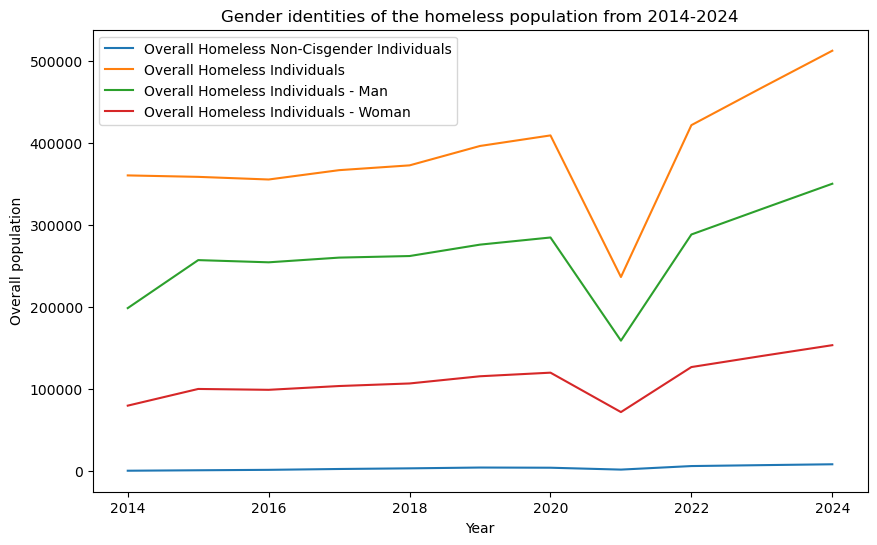

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Non-Cisgender Individuals',
            label='Overall Homeless Non-Cisgender Individuals')
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Individuals',
            label='Overall Homeless Individuals')
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Individuals - Man',
            label='Overall Homeless Individuals - Man')
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Individuals - Woman',
            label='Overall Homeless Individuals - Woman')

plt.title('Gender identities of the homeless population from 2014-2024')
plt.xlabel('Year')
plt.ylabel('Overall population')

In comparing these populations, I wanted to see what the ratio was between them. Before I even noted the difference between the plotted lines, I saw the drastic dip in the year 2021. We'll look into this further down the line, but for now I want to compare these categories.    
    
As you can see, non-cisgender individuals only make up **1.66%** of the total population of homeless individuals as of 2024, and even less in previous years. It is important to remember that the overall population of transgender people represents around 1% of the total US population. According to the [USAFacts calculations using Census Bureau data collected in 2024](https://usafacts.org/articles/what-percentage-of-the-us-population-is-transgender/), this makes up about **2.3 million people.**   
__________________________________________________________________________  
With that being said, I would like to take a closer look at how the number of homeless individuals who do not identify as cisgender has evolved over the last decade.

Text(0.5, 1.0, 'Count of non-cisgender homeless individuals from 2014-2024')

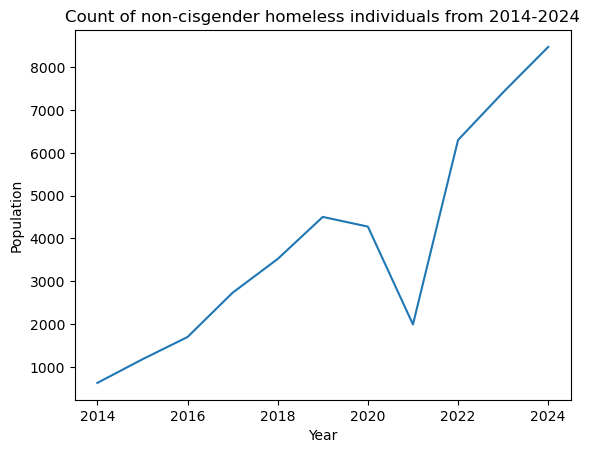

In [24]:
# creating a line plot to demonstrate
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Non-Cisgender Individuals',
            )

plt.ylabel('Population')
plt.title('Count of non-cisgender homeless individuals from 2014-2024')

When we take a closer look at the population of non-cisgender homeless individuals over the last decade, we can observe that there is a **substantial** increase, as you will see in my calculations.
  
**TO INCLUDE RESEARCH AND ELABORATION ON POTENTIAL REASONS FOR INCREASE**
  
https://translegislation.com/learn

https://williamsinstitute.law.ucla.edu/publications/trans-adults-united-states/
________________

# Let's take a closer look at the count of overall homeless individuals in the last decade: 

Text(0.5, 1.0, 'Overall Count of homeless individuals from 2014-2024')

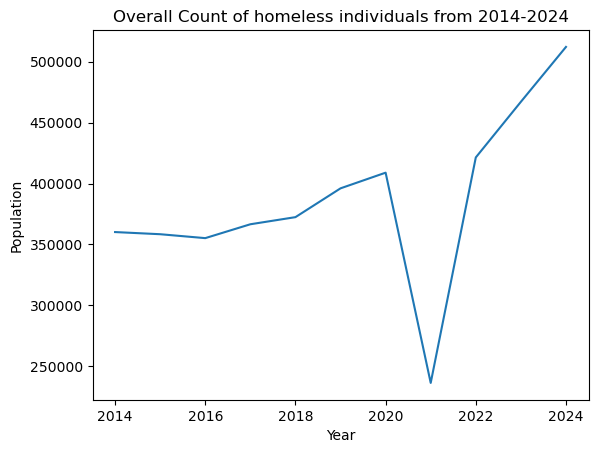

In [52]:
# creating a line plot to visualize the evolving population

sns.lineplot(data=gender_only_totals, 
             x='Year', 
             y='Overall Homeless Individuals',
             label='')
plt.ylabel('Population')
plt.title('Overall Count of homeless individuals from 2014-2024')

I want to start off with that large dip that we've seen in each category we've looked at so far. Why is there such a steep decrease in population count in 2021? According to the HUD's [Annual Homelessness Assessment Report for 2021](https://www.huduser.gov/portal/datasets/ahar/2021-ahar-part-1-pit-estimates-of-homelessness-in-the-us.html), HUD encouraged caution in conducting unsheltered PIT counts in response to the COVID-19 pandemic. They did not want the CoC's to risk furthering the spread of COVID-19 due to the lack of widespread vaccinations to prevent the illness. Because of this, there is a significant gap in information surrounding that year.
  
Now that the dip has been addressed, I want to look at the upward trend in overall homeless population. The only time there was any decrease in population (ignoring the anomaly that was 2021) was between the years 2014 and 2016, where it was slightly decreasing. After that, there was quite a large increase.
  
I will now calculate the increase for each of the populations we have observed so far:

In [53]:
# calculating the difference in overall homeless individuals from 2014 and 2024

overall_flat_diff = gender_only_totals['Overall Homeless Individuals'][0] - gender_only_totals['Overall Homeless Individuals'][10]
overall_percent_increase = np.round((overall_flat_diff / gender_only_totals['Overall Homeless Individuals'][10]) * 100, 2)

man_flat_diff = gender_only_totals['Overall Homeless Individuals - Man'][0] - gender_only_totals['Overall Homeless Individuals - Man'][10]
man_percent_increase = np.round((man_flat_diff / gender_only_totals['Overall Homeless Individuals - Man'][10]) * 100, 2)

woman_flat_diff = gender_only_totals['Overall Homeless Individuals - Woman'][0] - gender_only_totals['Overall Homeless Individuals - Woman'][10]
woman_percent_increase = np.round((woman_flat_diff / gender_only_totals['Overall Homeless Individuals - Woman'][10]) * 100, 2)

noncis_flat_diff = gender_only_totals['Overall Homeless Non-Cisgender Individuals'][0] - gender_only_totals['Overall Homeless Non-Cisgender Individuals'][10]
noncis_percent_increase = np.round((noncis_flat_diff / gender_only_totals['Overall Homeless Non-Cisgender Individuals'][10]) * 100, 2)


print('The population of overall male homeless individuals increased by ' + str(man_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(man_percent_increase) + ' percent.\n')

print('The population of overall female homeless individuals increased by ' + str(woman_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(woman_percent_increase) + ' percent.\n')

print('The population of overall non-cisgender homeless individuals increased by ' + str(noncis_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(noncis_percent_increase) + ' percent.\n')

print('The population of overall homeless individuals increased by ' + str(overall_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(overall_percent_increase) + ' percent.\n')

The population of overall male homeless individuals increased by 151418 people from 2014 to 2024, which is an increase of 76.23 percent.

The population of overall female homeless individuals increased by 73610 people from 2014 to 2024, which is an increase of 92.17 percent.

The population of overall non-cisgender homeless individuals increased by 7849 people from 2014 to 2024, which is an increase of 1255.84 percent.

The population of overall homeless individuals increased by 151818 people from 2014 to 2024, which is an increase of 42.15 percent.



___

Looking at the columns in these tables, they often refer to different kinds of sheltered homeless people: **SH**, **ES**, and **TH**. These are abbreviations for **Safe Haven**, **Emergency Shelter**, and **Transitional Housing** respectively. 